In [1]:
!pip install datasets pandas matplotlib seaborn wordcloud nltk transformers scikit-learn

###Loading and Preprocessing the Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")

for split in dataset.keys():
    print(f"--- {split} Split ---")
    print(dataset[split].column_names)
    print(dataset[split].shape)
    print(dataset[split][0])
    print()

# Basic info about the dataset
print("Dataset Structure: ", dataset)

train_data = dataset['train']
print("Training Data: ", train_data)

missing_values = {column: sum([1 for row in train_data[column] if row is None or row == '']) for column in train_data.column_names}
print("Missing Values: ", missing_values)


--- train Split ---
['text', 'label']
(25000, 2)
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Rea

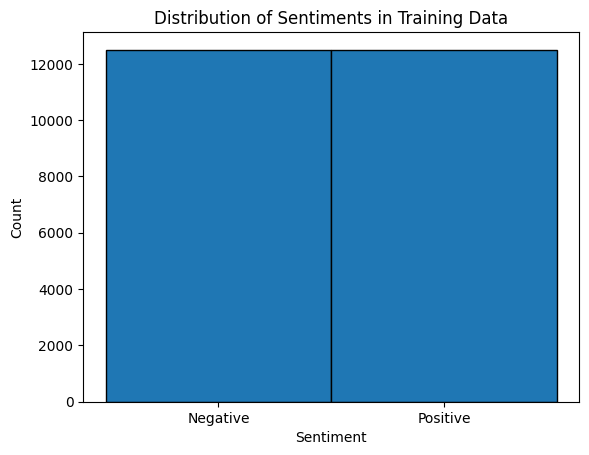

In [23]:
import matplotlib.pyplot as plt

train_data_sentiments = [int(example['label']) for example in train_data]
plt.hist(train_data_sentiments, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Training Data')
plt.show()


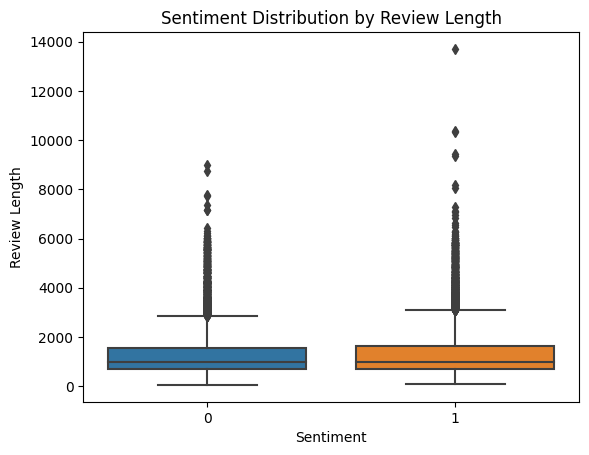

In [4]:
import seaborn as sns

# Visualization: Sentiment distribution by review length
review_lengths = [len(example['text']) for example in train_data]
sentiments = [example['label'] for example in train_data]

sns.boxplot(x=sentiments, y=review_lengths)
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.title('Sentiment Distribution by Review Length')
plt.show()

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
print(f"Number of training posts: {len(newsgroups_train.data)}")
print(f"Number of test posts: {len(newsgroups_test.data)}")

Number of training posts: 11314
Number of test posts: 7532


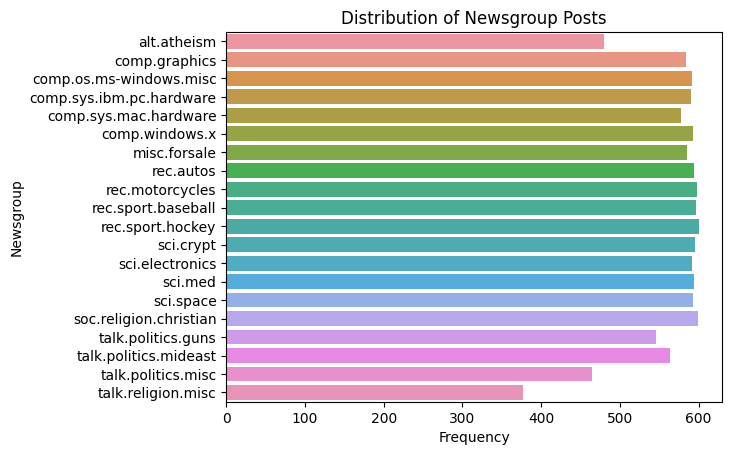

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

targets, frequency = np.unique(newsgroups_train.target, return_counts=True)
targets_str = [newsgroups_train.target_names[i] for i in targets]

sns.barplot(x=frequency, y=targets_str)
plt.xlabel('Frequency')
plt.ylabel('Newsgroup')
plt.title('Distribution of Newsgroup Posts')
plt.show()

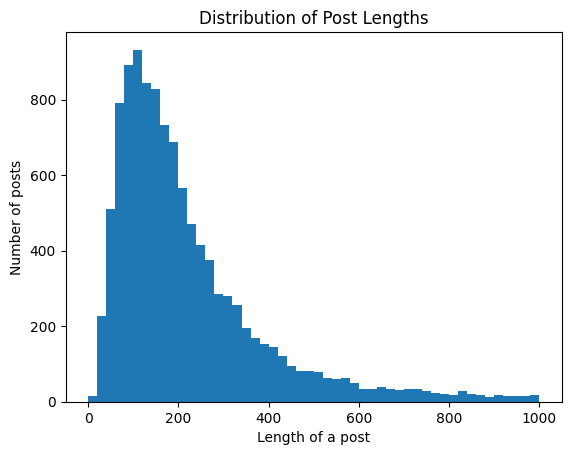

In [8]:
post_lengths = [len(text.split()) for text in newsgroups_train.data]
plt.hist(post_lengths, bins=50, range=(0, 1000))
plt.xlabel('Length of a post')
plt.ylabel('Number of posts')
plt.title('Distribution of Post Lengths')
plt.show()

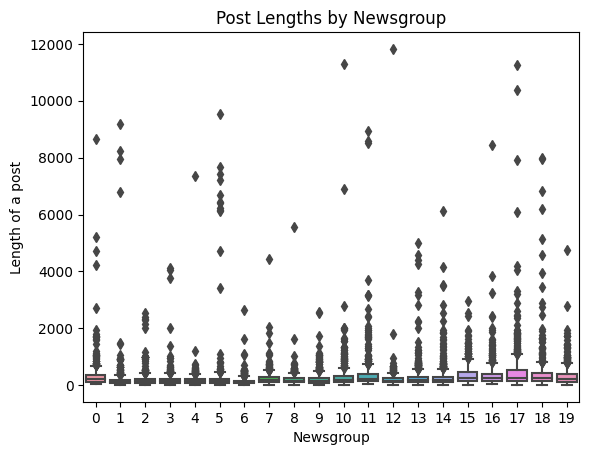

In [9]:
# Visualize the distribution of post lengths by newsgroup
sns.boxplot(x=newsgroups_train.target, y=post_lengths)
plt.xlabel('Newsgroup')
plt.ylabel('Length of a post')
plt.title('Post Lengths by Newsgroup')
plt.show()


###Processing the 20 Newsgroups Dataset

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [11]:
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = newsgroups_data.data
labels = newsgroups_data.target

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(texts):
    return [" ".join(tokenizer.tokenize(text)) for text in texts]

train_data = preprocess(train_data)
test_data = preprocess(test_data)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1301 > 512). Running this sequence through the model will result in indexing errors


In [12]:
model = AutoModel.from_pretrained("distilbert-base-uncased")

def encode_with_dropout(model, sentences):
    model.train()
    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    outputs = model(**encoded_inputs)
    return outputs.last_hidden_state[:, 0, :]

def fine_tune_model(model, train_loader, learning_rate=2e-5, epochs=5):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :]
            loss = torch.nn.functional.cross_entropy(embeddings, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
def encode_texts(texts):
    encoded_batch = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

input_ids, attention_masks = encode_texts(train_data)
labels = torch.tensor(train_labels)

train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
fine_tune_model(model, train_loader)

In [ ]:
train_embeddings = encode_with_dropout(model, train_data).detach().cpu().numpy()
nn_classifier = KNeighborsClassifier(n_neighbors=5)
nn_classifier.fit(train_embeddings, train_labels)

In [ ]:
def predict_label(embedding):
    return nn_classifier.predict(embedding.reshape(1, -1))

def evaluate_model(model, test_data, test_labels):
    model.eval()  # Disable dropout for evaluation
    predictions = []
    for sentence in test_data:
        with torch.no_grad():
            encoded_input = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
            output = model(**encoded_input)
            sentence_embedding = output.last_hidden_state[:, 0, :].detach().numpy()
            predicted_label = predict_label(sentence_embedding)
            predictions.append(predicted_label[0])
    return accuracy_score(test_labels, predictions)

accuracy = evaluate_model(model, test_data, test_labels)
print("Model Accuracy:", accuracy)

##Train Semi-Supervised Model with Fraction of Data

In [ ]:
def train_with_reduced_data(model, train_data, train_labels, fraction):
    frac_data, _, frac_labels, _ = train_test_split(train_data, train_labels, train_size=fraction, random_state=42)

    input_ids, attention_masks = encode_texts(frac_data)
    labels = torch.tensor(frac_labels)
    reduced_dataset = TensorDataset(input_ids, attention_masks, labels)
    reduced_loader = DataLoader(reduced_dataset, batch_size=16, shuffle=True)

    fine_tune_model(model, reduced_loader)

fractions = [1, 0.5, 0.25, 0.1, 0.05]
for frac in fractions:
    print(f"Training with {frac * 100}% of labeled data")
    train_with_reduced_data(model, train_data, train_labels, frac)


In [ ]:
def evaluate_model_on_test_set(model, test_data, test_labels):
    model.eval()  # Disable dropout for evaluation
    predictions = []
    for sentence in test_data:
        with torch.no_grad():
            encoded_input = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
            output = model(**encoded_input)
            sentence_embedding = output.last_hidden_state[:, 0, :].detach().numpy()
            predicted_label = predict_label(sentence_embedding)
            predictions.append(predicted_label[0])
    return evaluate_model(model, test_data, test_labels)

accuracy_results = {}

for frac in fractions:
    model.load_state_dict(torch.load(f"model_with_{frac}_data.pth"))
    accuracy = evaluate_model_on_test_set(model, test_data, test_labels)
    accuracy_results[frac] = accuracy
    print(f"Accuracy with {frac * 100}% of labeled data: {accuracy}")

fully_supervised_accuracy = accuracy_results[1]
min_required_fraction = min(frac for frac, acc in accuracy_results.items() if acc >= fully_supervised_accuracy - threshold)
print(f"Minimum fraction of labeled data required: {min_required_fraction * 100}%")

##Processing the IMDb Dataset

In [24]:
train_data_imdb = imdb_data['train']['text']
test_data_imdb = imdb_data['test']['text']
train_labels_imdb = imdb_data['train']['label']
test_labels_imdb = imdb_data['test']['label']

train_data_imdb = preprocess(train_data_imdb)
test_data_imdb = preprocess(test_data_imdb)

In [17]:
# Modify the fine-tuning function for binary classification
def fine_tune_model_binary(model, train_loader, learning_rate=2e-5, epochs=4):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels.float())
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

In [ ]:
from sklearn.linear_model import LogisticRegression

# Encode training data with dropout and train a logistic regression model
train_embeddings = encode_with_dropout(model, train_data).detach().cpu().numpy()
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(train_embeddings, train_labels)

In [ ]:
def predict_label_binary(embedding):
    return log_reg_classifier.predict(embedding.reshape(1, -1))